In [28]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

from DAE_dataset_helper import OrigamiDatasetGenerate
from DAE_dataset_helper import ToTensor,Grayscale,Resize,Normalize
from DAE_model import DenoisingAE #, AugmentedAutoencoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
# from shutil import copyfile
# num_imgs = 8

# lists = list(os.listdir('/home/rohit/projects/autoencoder/OrigamiData/Images'))
# for i,file in enumerate(lists):
#     copyfile('/home/rohit/projects/autoencoder/OrigamiData/Images/'+file, '/home/rohit/projects/autoencoder/sample_dataset/'+file)
#     if i == num_imgs:
#         break

In [38]:
class AugmentedAutoencoder(nn.Module):
    def __init__(self):
        super(AugmentedAutoencoder, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.en_conv1 = nn.Conv2d(3, 128, 2, stride=2) 
        self.en_conv2 = nn.Conv2d(128, 256, 2, stride=2)
        self.en_conv3 = nn.Conv2d(256, 256, 2, stride=2)
        self.en_conv4 = nn.Conv2d(256, 512, 2, stride=2)
        
        self.fc1 = nn.Linear(512*8*8, 128)
        self.fc2 = nn.Linear(128, 512*8*8)
        
        self.dc_conv2 = torch.nn.ConvTranspose2d(512,256,2, stride=2)
        self.dc_conv3 = torch.nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dc_conv4 = torch.nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dc_conv5 = torch.nn.ConvTranspose2d(128, 3, 2, stride=2)

    def forward(self, x):
        x = self.en_conv1(x) # N x 128 x 64 x 64
        x = F.relu(x) 
        
        x = self.en_conv2(x) # N x 256 x 32 x 32
        x = F.relu(x)
        
        x = self.en_conv3(x) # N x 256 x 16 x 16
        x = F.relu(x)
        
        x = self.en_conv4(x) # N x 512 x 8 x 8
        x = F.relu(x)
        
        
        x = torch.flatten(x, 1) # N x (512*8*8)       
        encoding = self.fc1(x) # N x 128        
        x = self.fc2(encoding) # N x (512*8*8)
        x = x.view(-1,512,8,8)


        x = self.dc_conv2(x) # N x 256 x 16 x 16
        x = F.relu(x)

        x = self.dc_conv3(x) # N x 256 x 32 x 32
        x = F.relu(x)
        
        x = self.dc_conv4(x) # N x 256 x 64 x 64
        x = F.relu(x)

        x = self.dc_conv5(x) # N x 3 x 128 x 128
        x = F.sigmoid(x)

        return x

# model = AugmentedAutoencoder()
# t = torch.rand([64, 3, 128, 128])
# model.forward(t).shape

In [39]:
train_batch_size = 64
test_batch_size = 64
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)), Normalize(), ToTensor() ])
origami = OrigamiDatasetGenerate(root_dir="sample_dataset",transform=trns)

train_loader = DataLoader(origami, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

Shape:  torch.Size([10, 3, 128, 128])
<built-in method max of type object at 0x7f326b9f6300>


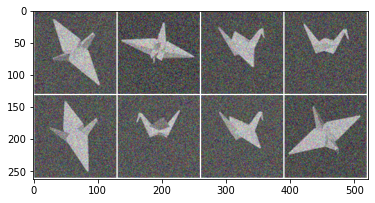

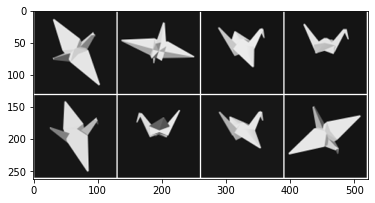

In [40]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']
print('Shape: ', augmented.shape)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images_show = 8
print(torch.max)
imshow(torchvision.utils.make_grid(augmented[:images_show,:], nrow=4, padding=2, pad_value=1))
imshow(torchvision.utils.make_grid(original[:images_show,:], nrow=4, padding=2, pad_value=1))

In [33]:
def train(model, device, train_loader, optimizer, epoch,log_interval=100):
    model.train()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target, reduction='sum')
        loss.backward()
        optimizer.step()
        
        if batch_idx % (40000//(train_batch_size*10)) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for sample in test_loader:
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output,target, reduction='sum') # sum up batch loss


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

model = AugmentedAutoencoder().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1e-2)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

save_model = False
epochs = 300

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader)

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/3 (0%)]	Loss: 21149.531250

Test set: Average loss: 7047.4390

Train Epoch: 2 [0/3 (0%)]	Loss: 21142.316406

Test set: Average loss: 7044.9453

Train Epoch: 3 [0/3 (0%)]	Loss: 21134.843750

Test set: Average loss: 7042.3408

Train Epoch: 4 [0/3 (0%)]	Loss: 21127.019531

Test set: Average loss: 7039.5620

Train Epoch: 5 [0/3 (0%)]	Loss: 21118.654297

Test set: Average loss: 7036.4014

Train Epoch: 6 [0/3 (0%)]	Loss: 21109.210938

Test set: Average loss: 7032.5127

Train Epoch: 7 [0/3 (0%)]	Loss: 21097.359375

Test set: Average loss: 7026.6240

Train Epoch: 8 [0/3 (0%)]	Loss: 21079.814453

Test set: Average loss: 7016.0771

Train Epoch: 9 [0/3 (0%)]	Loss: 21049.300781

Test set: Average loss: 6994.0112

Train Epoch: 10 [0/3 (0%)]	Loss: 20981.656250

Test set: Average loss: 6943.7510

Train Epoch: 11 [0/3 (0%)]	Loss: 20836.291016

Test set: Average loss: 6838.5596

Train Epoch: 12 [0/3 (0%)]	Loss: 20505.371094

Test set: Average loss: 6589.5898

Train Epoch: 13 [0/3 (0%)

Reconstructed


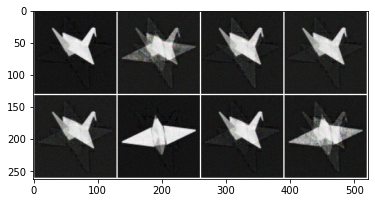

Original


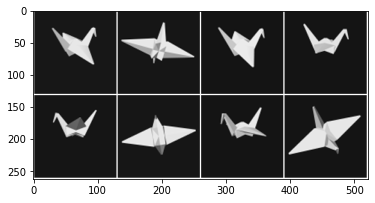

Input to Netowrk


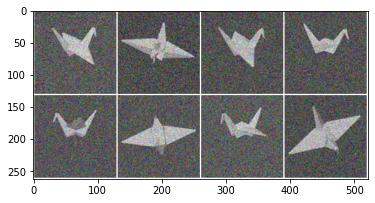

In [41]:
def cross_validation(model, device, test_loader,viewer=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        data, target = sample['augmented'],sample['original']
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        

    if viewer:
        images_show = 8
        
        print('Reconstructed')
        op = output[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(op, nrow=4, padding=2, pad_value=1))
        
        print('Original')
        imshow(torchvision.utils.make_grid(target[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))
        
        print('Input to Netowrk')
        imshow(torchvision.utils.make_grid(data[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))  
        
        
    return data,target, output



input_network, target, output = cross_validation(model, device, train_loader,viewer=True)

In [20]:
torch.min(output)

tensor(0., device='cuda:0')